In [60]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir('D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats'))

['test1.zip', 'sampleSubmission.csv', 'train.zip', 'test1', 'train']


### define constants

In [61]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### preparing Train Data
###### *cat -0
###### *dog-1

In [62]:
filenames = os.listdir(r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [63]:
df.head()

,filename,category
0,cat.10.jpg,0
1,cat.1.jpg,0
2,cat.10007.jpg,0
3,cat.10010.jpg,0
4,cat.10003.jpg,0


In [64]:
df.tail()

,filename,category
24995,dog.9981.jpg,1
24996,dog.9999.jpg,1
24997,dog.9998.jpg,1
24998,dog.9988.jpg,1
24999,dog.9997.jpg,1


<AxesSubplot:>

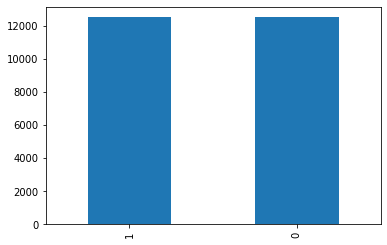

In [65]:
#balance확인
df['category'].value_counts().plot.bar()

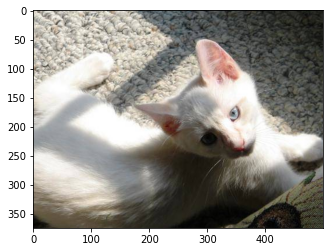

In [66]:
#샘플링 확인
sample = random.choice(filenames)
image = load_img(r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'+sample)
plt.imshow(image)

In [67]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) #cause cat and dog class

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

### LearningRate
###### 학습의 정확도 감시. 학습률 조정

In [68]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [69]:
df['category'] = df['category'].replace({0: 'cat', 1:'dog'})

In [70]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

### Train Data 분포 확인

<AxesSubplot:>

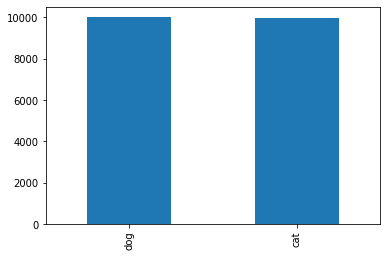

In [71]:
train_df['category'].value_counts().plot.bar()

### Validation 분포확인

<AxesSubplot:>

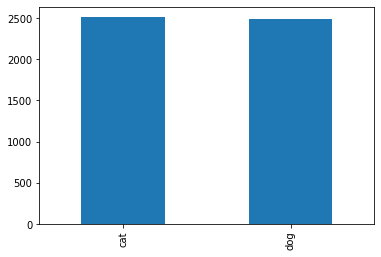

In [72]:
validate_df['category'].value_counts().plot.bar()

### 학습, 검증데이터 확인

In [73]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### augmentation

In [74]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    (r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'),
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### validation augmentation

In [75]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    (r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'),
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 5000 validated image filenames belonging to 2 classes.


### aumentation sample

In [76]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
     example_df,
     (r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'),
     x_col='filename',
     y_col='category',
     target_size=IMAGE_SIZE,
     class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


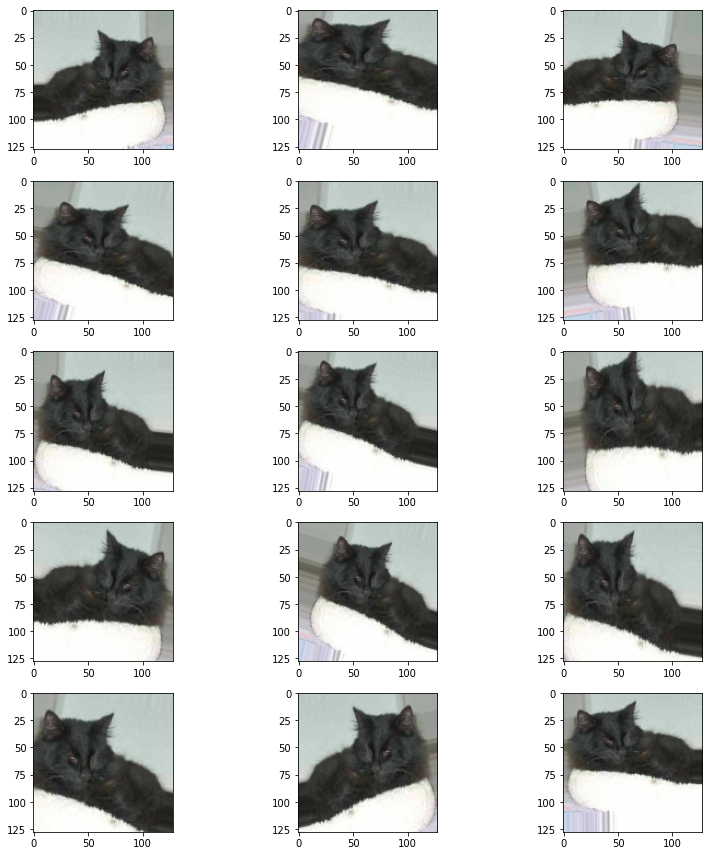

In [77]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for x_batch, y_batch in example_generator:
        image = x_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### fit

In [78]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/50
1333/1333 [==============================] - 632s 474ms/step - loss: 0.7445 - accuracy: 0.6305 - val_loss: 0.7617 - val_accuracy: 0.6676
Epoch 2/50
1333/1333 [==============================] - 604s 453ms/step - loss: 0.5671 - accuracy: 0.7137
Epoch 3/50
1333/1333 [==============================] - 597s 448ms/step - loss: 0.5100 - accuracy: 0.7559
Epoch 4/50
1333/1333 [==============================] - 606s 455ms/step - loss: 0.4715 - accuracy: 0.7803
Epoch 5/50
1333/1333 [==============================] - 651s 489ms/step - loss: 0.4406 - accuracy: 0.8000
Epoch 6/50
1333/1333 [==============================] - 602s 451ms/step - loss: 0.4218 - accuracy: 0.8072
Epoch 7/50
1333/1333 [==============================] - 600s 450ms/step - loss: 0.3952 - accuracy: 0.8241
Epoch 8/50
1333/1333 [==============================] - 601s 451ms/step - loss: 0.3909 - accuracy: 0.8249
Epoch 9/50
1333/1333 [==============================] - 600s 450ms/step - loss: 0.3818 - accuracy: 0.8320
Epoc

### save model

In [79]:
model.save_weights('model.h5')

### Virtualize Traning

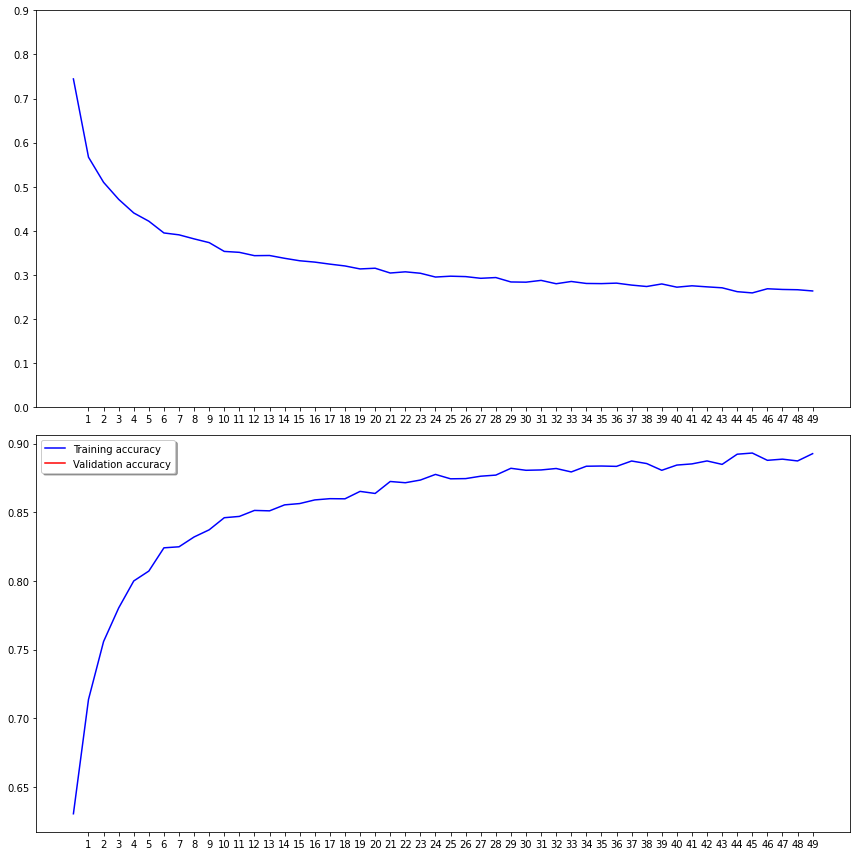

In [80]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='validation loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
ax2.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [81]:
#prepare testing data
test_filenames = os.listdir(r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\test1\test1/')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [82]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\test1\test1/',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [83]:
#predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [84]:
#개와 고양이일 확률중 보다 큰값에 해당하는 레이블을 선택해서 값 치환
test_df['category'] = np.argmax(predict, axis=-1)

In [85]:
test_df['category'] = test_df['category'].replace({ 1: 'dog', 0: 'cat' })

<AxesSubplot:>

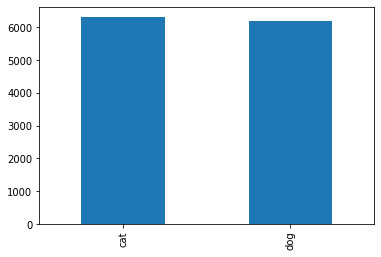

In [86]:
#Virtualize Result
test_df['category'].value_counts().plot.bar()

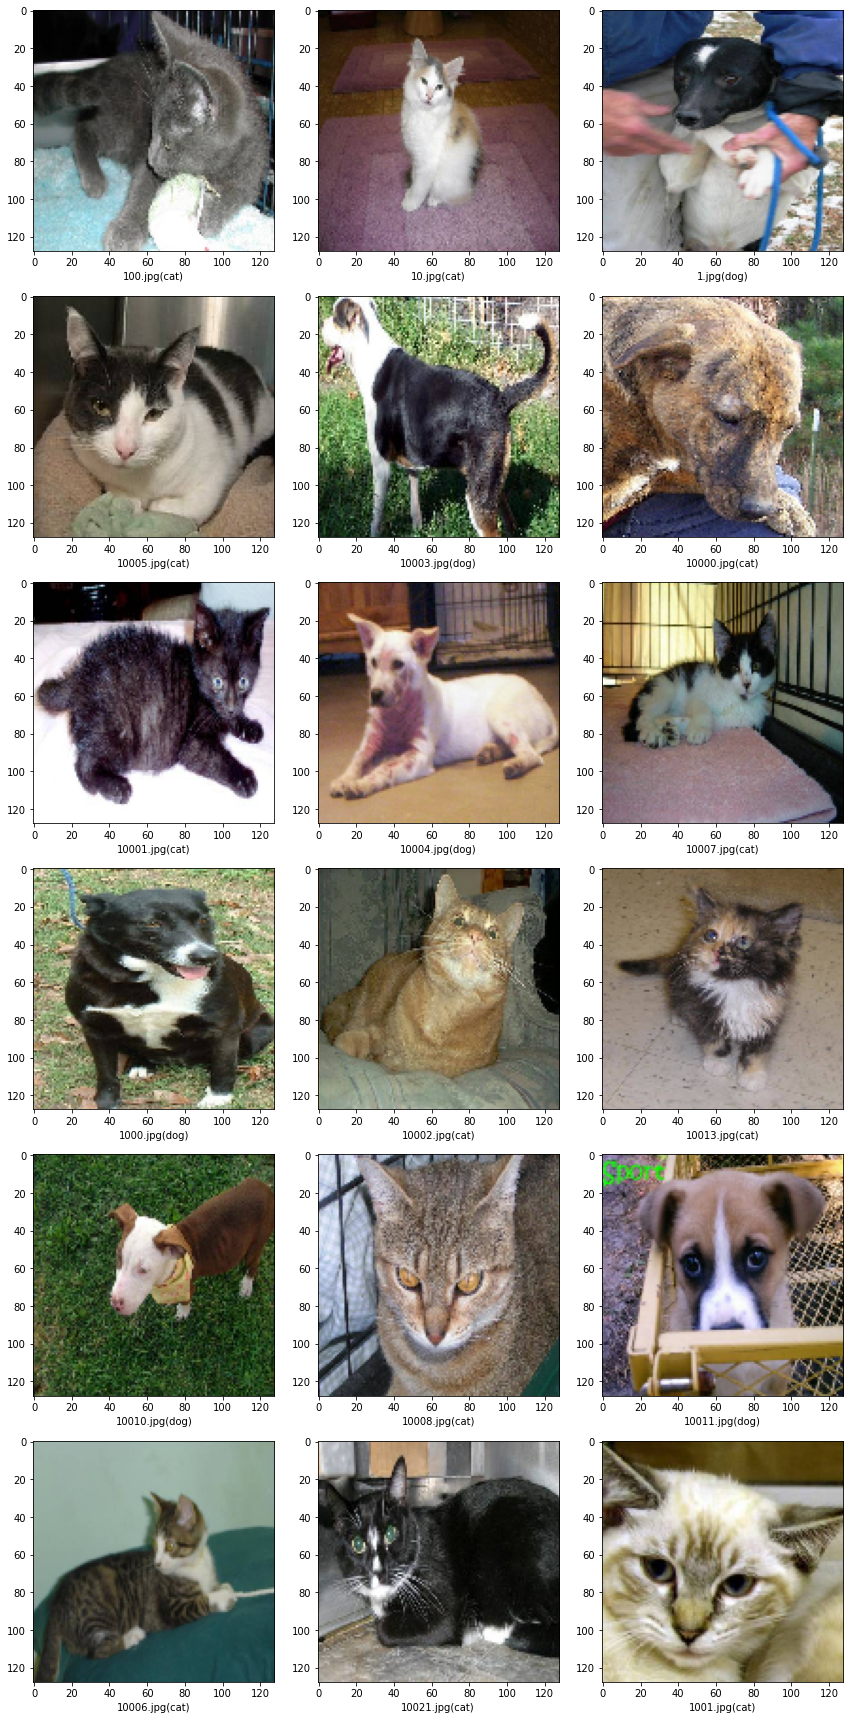

In [87]:
#see predicted result with images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\test1\test1/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + '{}'.format(category) + ')')
plt.tight_layout()
plt.show()